#  <font color='blue'>Project 5: Vehicle Detection and Tracking</font>
<div class= "alert alert-block alert-info"> *Detect and track vehicles using color and gradient features and a support vector machine classifier. *</div>

## Outline

This project aims to detect vehicles and track their position across frames in a video by using computer vision techniques Histogram of Oriented Gradient and vector machine classifier.
This project was done as following steps:
1. Drawing bouding boxes.
1. Compute Histogram of Oriented Gradients (HOG) on image dataset and extract HOG features to train a classifier.
1. Training classifiers to identify vehicles.

## Project Content

In [1]:
# Import some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import glob
import time
from moviepy.editor import VideoFileClip

from scipy.misc import imresize

from skimage.feature import hog
from skimage.io import imread
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Training Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn import linear_model, neural_network, ensemble, svm, naive_bayes

%matplotlib inline
#cv2.useOptimized()

### 1. Drawing bouding boxes
>  <font color='gray'>A function that takes as its arguments, an image, and a list of bounding box coordinates for each car　and then draw bounding boxes with `cv2.rectangle()`:<br>
`cv2.rectangle(image_to_draw_on, (x1, y1), (x2, y2), color, thick)`

>  - `image_to_draw_on`: the copy of image
>  - `(x1, y1) and (x2, y2)`: the x and y coordinates of any two opposing corners of the bounding box 
>  - `color`: a 3-tuple, for example, (0, 0, 255) for blue
>  - `thick`: an optional integer parameter to define the box thickness

In [2]:
def draw_bboxes(img, bboxes, color=(0, 255, 255), thick= (-1, 2) , alpha = 0.3):
    # make a copy of the image
    mask_overlay, mask_box = np.copy(img), np.copy(img) 
    
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(mask_overlay, bbox[0], bbox[1], color, thick[0])
        cv2.rectangle(mask_box, bbox[0], bbox[1], color, thick[1])

    output = cv2.addWeighted(mask_overlay, alpha, mask_box, 1- alpha, 0, mask_box)
    
    return output

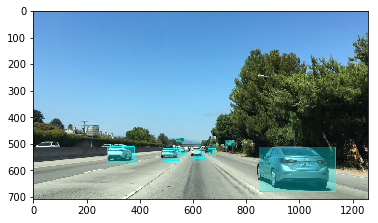

In [3]:
# Test 'draw_bboxes' function on images
bboxes = [((280, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]
image = mpimg.imread('test_images/bbox-example-image.jpg')
result = draw_bboxes(image, bboxes)
plt.imshow(result);

### 2. Compute Histogram of Oriented Gradients (HOG) on image dataset and extract HOG features to train a classifier
>  <font color='gray'>Udacity introduced method of extracting HOG features with Scikit-image package. But OpenCv also has its version. OpenCv version seems to be faster but less flexible than Scikit.<br>
>  - OpenCV: `cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)`<br> 
>  - Scikit: `hog(image,orientations,pixels_per_cell,cells_per_block,block_norm)` 

#### 2.1 Training Data Preparation and Exploration

In [4]:
# Set of vehicles and non-vehicles images for feature extraction and training a classifier.
cars    = glob.glob('Dataset/vehicles/vehicles/*/*.png')
notcars = glob.glob('Dataset/non-vehicles/non-vehicles/*/*.png')

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


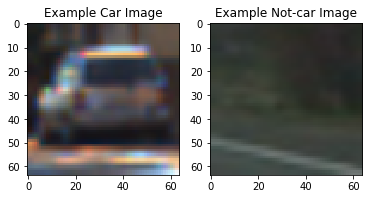

In [5]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind    = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image    = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [6]:
# Define a function to return HOG features and visualization
# To get hog features, use scikit's hog or OpenCV's HOGDescriptor
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,\
                     vis=False, feature_vec=True, method = "opencv"):
    
    if method == "scikit":
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    if method == "opencv":
        cell_size    = (pix_per_cell, pix_per_cell)
        block_size   = (cell_per_block, cell_per_block) 
        nbins        = orient
        #https://discussions.udacity.com/t/ways-to-improve-processing-time/237941/13
        hogCV = cv2.HOGDescriptor(_winSize     =(img.shape[1] // cell_size[1] * cell_size[1],img.shape[0] // cell_size[0] * cell_size[0]),
                                  _blockSize   =(block_size[1] * cell_size[1],block_size[0] * cell_size[0]),
                                  _blockStride =(cell_size[1], cell_size[0]),
                                  _cellSize    =(cell_size[1], cell_size[0]),
                                  _nbins       = nbins)

        return np.ravel(hogCV.compute(img))

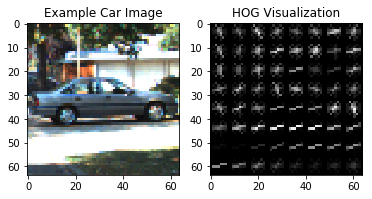

In [7]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient         = 9
pix_per_cell   = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block,\
                                       vis=True, feature_vec=False, method = "scikit")
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### 2.2 Extract  Features

In [8]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs,color_space='RGB',spatial_size=(32, 32),hist_bins=32,\
                     orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,\
                     spatial_feat=True,hist_feat=True,hog_feat=True,method = "opencv"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = imread(file) #mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
                
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                
                for channel in range(feature_image.shape[2]):  
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, method = method))
                """
                #https://codezine.jp/article/detail/8687
                hog_features = list(get_hog_features(feature_image[:,:,np.arange(feature_image.shape[2])], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, method = method))
                """
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, method = method)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
color_space    = 'Lab'  # Can be RGB, HSV, LUV, HLS, *YUV, *YCrCb, *Lab
orient         = 11     # HOG orientations
pix_per_cell   = 16     # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_channel    = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size   = (32,32)# Spatial binning dimensions
hist_bins      = 32     # Number of histogram bins
spatial_feat   = True   # Spatial features on or off
hist_feat      = False  # Histogram features on or off
hog_feat       = True   # HOG features on or off

In [10]:
# Extract features by OpenCV's HOG
start_t = time.time()

car_features_opencv = extract_features(cars, color_space=color_space,spatial_size=spatial_size,\
                                       hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,\
                                       cell_per_block=cell_per_block,hog_channel=hog_channel,\
                                       spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,\
                                       method = 'opencv')

notcar_features_opencv = extract_features(notcars, color_space=color_space,spatial_size=spatial_size,\
                                          hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,\
                                          cell_per_block=cell_per_block,hog_channel=hog_channel,\
                                          spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,\
                                          method = 'opencv')

stop_t = time.time()
print(round(stop_t-start_t,2), 'seconds to extract features by opencv method')

98.28 seconds to extract features by opencv method


In [11]:
# Extract features by Scikit's HOG
start_t = time.time()

car_features_scikit = extract_features(cars, color_space=color_space,spatial_size=spatial_size,\
                                       hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,\
                                       cell_per_block=cell_per_block,hog_channel=hog_channel,\
                                       spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,\
                                       method = 'scikit')


notcar_features_scikit = extract_features(notcars, color_space=color_space,spatial_size=spatial_size,\
                                          hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell,\
                                          cell_per_block=cell_per_block,hog_channel=hog_channel,\
                                          spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,\
                                          method = 'scikit')

stop_t = time.time()
print(round(stop_t-start_t,2), 'seconds to extract features by scikit')

82.06 seconds to extract features by scikit


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4260


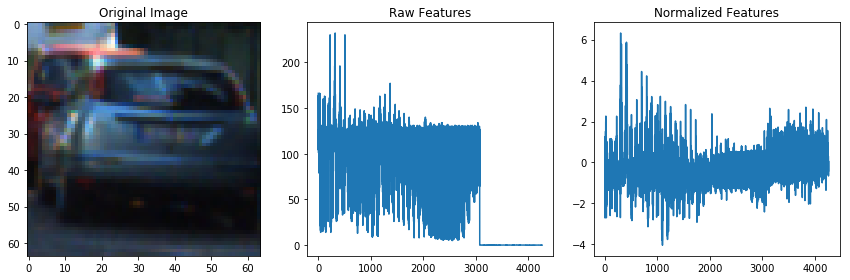

In [12]:
car_features    = car_features_opencv
notcar_features = notcar_features_opencv
# Sclae features
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')
    
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

### 3. Training classifiers
>   <font color='gray'>There are various classifier from `sklearn` and each classifier results with different accuracy and time to predict. For example, Support Vector Classifier (`LinearSVC()`),  Logistic Regression Classifier (`LogisticRegression()`), Gradient Boosting Classifier (`GradientBoostingClassifier()`) , Multi-Layer Perceptron Classifier (`MLPClassifier()`)

>   Below is `training_classifier` function, which features a variety of classifier. With the same input, <b>Multi-Layer Perception Classifier</b> is the most accurate one so I chose this classifier for detecting vehicle.

#### 3.1 Training classifier on positive and negative samples

In [13]:
def training_classifier(classifier = "SVC"):
    if classifier == "SVC":
        # Support Vector Classifier
        train_class = LinearSVC()
    elif classifier == "LRC":
        # Logistic Regression Classifier
        train_class = LogisticRegression()
    elif classifier == "MLPC":
        # Multi-Layer Perceptron Classifier
        train_class = MLPClassifier(solver='sgd',learning_rate_init=0.01,max_iter=10000)
    elif classifier == "GBC":
        # Gradient Boosting Classifier
        train_class = ensemble.GradientBoostingClassifier(random_state= 42)
    elif classifier == "BC":
        # Bagging Classifier
        train_class = ensemble.BaggingClassifier(random_state= 42)
    elif classifier == "GauNB":
        # Gaussian Naive Bayes
        train_class = naive_bayes.GaussianNB()
    elif classifier == "SGDC":
        # SGD Classifier
        train_class = linear_model.SGDClassifier(random_state= 42)
    elif classifier == "NuSVC":
        # NuSVC
        train_class = svm.NuSVC(random_state= 42)    
    
    # Check the training time
    t=time.time()
    train_class.fit(X_train, y_train)
    t2 = time.time()
    print(t2-t, 'Seconds to train this classifier...')
    # Check the score of this classifier
    print('Train Accuracy of this classifier = ', round(train_class.score(X_train, y_train),4))
    print('Test  Accuracy of this classifier = ', round(train_class.score(X_test, y_test),4))
    
    # Check the prediction time for a single sample
    t=time.time()
    prediction = train_class.predict(X_test[0].reshape(1, -1))
    t2 = time.time()
    print(t2-t, 'Seconds to predict')
    return train_class

In [14]:
SVC = training_classifier(classifier = "SVC")

49.44394397735596 Seconds to train this classifier...
Train Accuracy of this classifier =  1.0
Test  Accuracy of this classifier =  0.9885
0.21602153778076172 Seconds to predict


In [21]:
from sklearn.grid_search import GridSearchCV
# Create Parameter Candidates
parameters = {
    'C':[0.001, 0.01, 0.1, 1, 3, 5, 10, 100],
    'loss':('hinge', 'squared_hinge'),
    }
#Conduct Grid Search To Find Parameters Producing Highest Score
clf = GridSearchCV(svm.LinearSVC(), parameters)
clf.fit(X_train, y_train)
GS_loss, GS_C = clf.best_params_.values()
print ("Best Parameters：{}".format(clf.best_params_))

#Train a new classifier using the best parameters found by the grid search
#svm.LinearSVC(C= GS_C, loss = GS_loss).fit(X_train, y_train).score(X_test, y_test)
SVC = LinearSVC(C= GS_C, loss = GS_loss)
SVC.fit(X_train, y_train)
# Check the score of this classifier
print('Train Accuracy of this classifier = ', round(SVC.score(X_train, y_train),4))
print('Test  Accuracy of this classifier = ', round(SVC.score(X_test, y_test),4))

Best Parameters：{'loss': 'squared_hinge', 'C': 0.001}
Train Accuracy of this classifier =  0.9997
Test  Accuracy of this classifier =  0.9907


In [22]:
LRC = training_classifier(classifier = "LRC")

30.371036767959595 Seconds to train this classifier...
Train Accuracy of this classifier =  1.0
Test  Accuracy of this classifier =  0.9907
0.05200505256652832 Seconds to predict


In [23]:
MLPC = training_classifier(classifier = "MLPC")

39.426942348480225 Seconds to train this classifier...
Train Accuracy of this classifier =  1.0
Test  Accuracy of this classifier =  0.9961
0.05400538444519043 Seconds to predict


In [24]:
GBC = training_classifier(classifier = "GBC")

586.7122220993042 Seconds to train this classifier...
Train Accuracy of this classifier =  0.9987
Test  Accuracy of this classifier =  0.9907
0.0 Seconds to predict


In [25]:
BC = training_classifier(classifier = "BC")

521.2556409835815 Seconds to train this classifier...
Train Accuracy of this classifier =  0.999
Test  Accuracy of this classifier =  0.9727
0.0020003318786621094 Seconds to predict


In [26]:
GauNB = training_classifier(classifier = "GauNB")

2.5462546348571777 Seconds to train this classifier...
Train Accuracy of this classifier =  0.9293
Test  Accuracy of this classifier =  0.9212
0.0 Seconds to predict


In [27]:
SGDC = training_classifier(classifier = "SGDC")

0.788078784942627 Seconds to train this classifier...
Train Accuracy of this classifier =  0.996
Test  Accuracy of this classifier =  0.9868
0.0 Seconds to predict


In [28]:
NuSVC = training_classifier(classifier = "NuSVC")

869.2889249324799 Seconds to train this classifier...
Train Accuracy of this classifier =  0.9707
Test  Accuracy of this classifier =  0.9688
0.032000064849853516 Seconds to predict


In [29]:
# Save best classifer and Scaler
joblib.dump(MLPC, 'Dataset/MLPC_classifier.pkl')
joblib.dump(SVC, 'Dataset/SVC_classifier.pkl')
joblib.dump(X_scaler, 'Dataset/scaler.pkl')

['Dataset/scaler.pkl']

#### 3.2 Apply hard-negative mining.

### 4. Searching Vehicle Method

#### 4.1 Sliding Windows Method

In [30]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def add_windows(xs,ys,xy_window0=None,xy_window1=None,\
               x_start_stop=None,y_start_stop=None,\
               nx_pix_per_step=None,ny_pix_per_step=None,\
               window_list=None):
    
    startx = xs*nx_pix_per_step + x_start_stop
    endx   = startx + xy_window0
    starty = ys*ny_pix_per_step + y_start_stop
    endy   = starty + xy_window1
    # Append window position to list
    return ((startx, starty), (endx, endy))
    #window_list.append(((startx, starty), (endx, endy)))
    
def slide_window(img,x_start_stop=[None, None],y_start_stop=[None, None],\
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    window_list.extend(add_windows(xs,ys,xy_window0=xy_window[0],xy_window1=xy_window[1],\
                         x_start_stop=x_start_stop[0],y_start_stop=y_start_stop[0],\
                         nx_pix_per_step=nx_pix_per_step,ny_pix_per_step=ny_pix_per_step,\
                         window_list=window_list) 
                       for ys in range(ny_windows)
                       for xs in range(nx_windows))
    """
    list = [add_windows(xs,ys,xy_window0=xy_window[0],xy_window1=xy_window[1],\
                         x_start_stop=x_start_stop[0],y_start_stop=y_start_stop[0],\
                         nx_pix_per_step=nx_pix_per_step,ny_pix_per_step=ny_pix_per_step,\
                         window_list=window_list)
             for ys in range(ny_windows)
             for xs in range(nx_windows)]
    """
    return window_list

In [31]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img,color_space='RGB',spatial_size=(32, 32),hist_bins=32,\
                        orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,\
                        spatial_feat=True,hist_feat=True,hog_feat=True,method = "opencv"):    

    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)    
    else: feature_image = np.copy(img)      
    

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True, method = method))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, 
                                            feature_vec=True, method = method)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows,clf,scaler,color_space='RGB',\
                   spatial_size=(32, 32),hist_bins=32,hist_range=(0, 256),\
                   orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,\
                   spatial_feat=True,hist_feat=True,hog_feat=True,\
                   classifier = "mlpc", method = "opencv"):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,color_space=color_space,\
                                       spatial_size=spatial_size,hist_bins=hist_bins,\
                                       orient=orient, pix_per_cell=pix_per_cell,\
                                       cell_per_block=cell_per_block,\
                                       hog_channel=hog_channel,spatial_feat=spatial_feat,\
                                       hist_feat=hist_feat,hog_feat=hog_feat,method = method)

        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        if classifier == "svc":
            #prediction = clf.predict(test_features)
            decision   = clf.decision_function(test_features)
            prediction = int(decision > 0.3)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        if classifier == "mlpc":
            prediction = clf.predict_proba(test_features)[0][1]
            if prediction > .99:
                on_windows.append(window)
   
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [32]:
# Load classifier and Scaler
#classifier = joblib.load('Dataset/MLPC_classifier.pkl')
classifier = joblib.load('Dataset/SVC_classifier.pkl')
X_scaler   = joblib.load('Dataset/scaler.pkl')

0.34 Seconds to proceed...


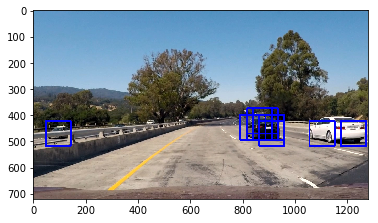

In [37]:
image_test = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image_test)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
t=time.time()
scales = [((96,96),[350,550], (0.75,0.75)),((160,160), [450,700], (0.55,0.55))]

windows = []
for window_size, y_size, overlap in scales:
    window = slide_window(image_test, x_start_stop=[None, None], y_start_stop= y_size, 
                           xy_window= window_size, xy_overlap= overlap)
    windows.extend(window)

hot_windows = search_windows(image_test,windows,classifier,X_scaler,color_space=color_space,\
                             spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,\
                             pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,\
                             hog_channel=hog_channel,spatial_feat=spatial_feat,\
                             hist_feat=hist_feat,hog_feat=hog_feat,\
                             classifier = "svc", method = "opencv")                       
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to proceed...')
plt.imshow(window_img)

In [56]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 1:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2
        else:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels, color=(0, 255, 255), thick= (-1, 2) , alpha = 0.3):
    # make a copy of the image
    mask_overlay, mask_box = np.copy(img), np.copy(img) 
    carlist = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        carlist.append(bbox)
        # Draw the box on the image
        cv2.rectangle(mask_overlay, bbox[0], bbox[1], color, thick[0])
        cv2.rectangle(mask_box, bbox[0], bbox[1], color, thick[1])   
    
    output = cv2.addWeighted(mask_overlay, alpha, mask_box, 1- alpha, 0, mask_box)
    
    # Return the image
    return output, carlist

1 cars detected


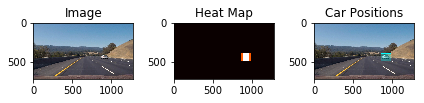

In [62]:
from scipy.ndimage.measurements import label

# Read in image similar to one shown above 
heat = np.zeros_like(image_test[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, carlist = draw_labeled_bboxes(np.copy(image_test), labels)

fig = plt.figure()
plt.subplot(131)
plt.imshow(image_test)
plt.title('Image')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(draw_img)
plt.title('Car Positions')
fig.tight_layout()
print (len(carlist), 'cars detected')

### 6. Pipeline in ONE-FRAME

In [63]:
def process_image(image, viz_heat = False):
    
    scales = [((96,96),[350,550], (0.75,0.75)),((160,160), [450,700], (0.65,0.65))]

    windows = []  
    for window_size, y_size, overlap in scales:
        window = slide_window(image, x_start_stop=[None, None], y_start_stop= y_size, 
                           xy_window= window_size, xy_overlap= overlap)
        windows.extend(window)
    hot_windows = search_windows(image,windows,classifier,X_scaler,color_space=color_space,\
                                 spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,\
                                 pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,\
                                 hog_channel=hog_channel,spatial_feat=spatial_feat,\
                                 hist_feat=hist_feat,hog_feat=hog_feat,\
                                 classifier = "svc", method = "opencv")

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img,_ = draw_labeled_bboxes(np.copy(image), labels)
    if viz_heat == True:
        return heatmap
    else:
        return draw_img
    

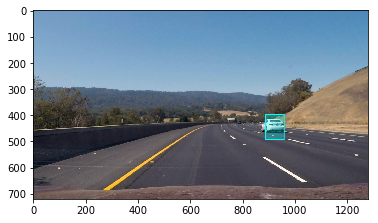

In [64]:
processed_image = process_image(mpimg.imread('test_images/test3.jpg'))
plt.imshow(processed_image)

In [43]:
def expand(x, exp=50):
    X0 = min(x[0][0],x[1][0])-exp
    X1 = max(x[0][0],x[1][0])+exp
    Y0 = min(x[0][1],x[1][1])-exp
    Y1 = max(x[0][1],x[1][1])+exp
    return ((X0,Y0),(X1,Y1))

0.26 Seconds to proceed...


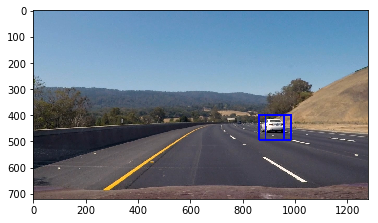

In [45]:
image_test = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image_test)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
t=time.time()
scales = [((96,96),[350,550], (0.75,0.75)),((160,160), [450,700], (0.55,0.55))]
carlist = [((888, 398), (959, 493))]
carlist = [expand(x) for x in carlist]
windows = []
for window_size, y_size, overlap in scales:
    window = slide_window(image_test, x_start_stop=[None, None], y_start_stop= y_size, 
                           xy_window= window_size, xy_overlap= overlap)
    windows.extend(window)

hot_windows = search_windows(image_test,windows,classifier,X_scaler,color_space=color_space,\
                             spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,\
                             pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,\
                             hog_channel=hog_channel,spatial_feat=spatial_feat,\
                             hist_feat=hist_feat,hog_feat=hog_feat,\
                             classifier = "svc", method = "opencv")                       
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to proceed...')
plt.imshow(window_img)

0.001 Seconds to proceed...
0.10501 Seconds to proceed...


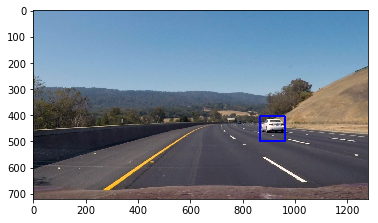

In [65]:
image_test = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image_test)

t=time.time()
carlist = [((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493)),\
           ((888, 398), (959, 493))]
carlist = [expand(x) for x in carlist]
newwindows = []
for x in carlist:
    thiswindow = slide_window(image_test,\
                           x_start_stop= [min(x[0][0],x[1][0]),max(x[0][0],x[1][0])],\
                           y_start_stop= [min(x[0][1],x[1][1]),max(x[0][1],x[1][1])],\
                           xy_window= (96,96), xy_overlap= (0.7,0.7)) 
    newwindows.extend(thiswindow)
t2 = time.time()
hot_windows = search_windows(image_test,newwindows,classifier,X_scaler,color_space=color_space,\
                             spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,\
                             pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,\
                             hog_channel=hog_channel,spatial_feat=spatial_feat,\
                             hist_feat=hist_feat,hog_feat=hog_feat,\
                             classifier = "svc", method = "opencv")
window_img1 = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
t3 = time.time()
print(round(t2-t, 5), 'Seconds to proceed...')
print(round(t3-t2, 5), 'Seconds to proceed...')
plt.imshow(window_img1)

In [47]:
def display(dir, size):
    fig,ax = plt.subplots(figsize= size)
    i =1
    
    files_infolder = glob.glob(dir)
    for img in files_infolder:
        image = mpimg.imread(img)
        plt.subplot(len(files_infolder),3, i)
        plt.title('Original Image')
        plt.imshow(image)
        
        plt.subplot(len(files_infolder),3, i+1)
        plt.title('Heat Map')
        plt.imshow(process_image(image,viz_heat = True), cmap='hot')
        
        plt.subplot(len(files_infolder),3, i+2)
        plt.title('Car Positions')
        plt.imshow(process_image(image))
        
        i= i+3
    
    plt.show()

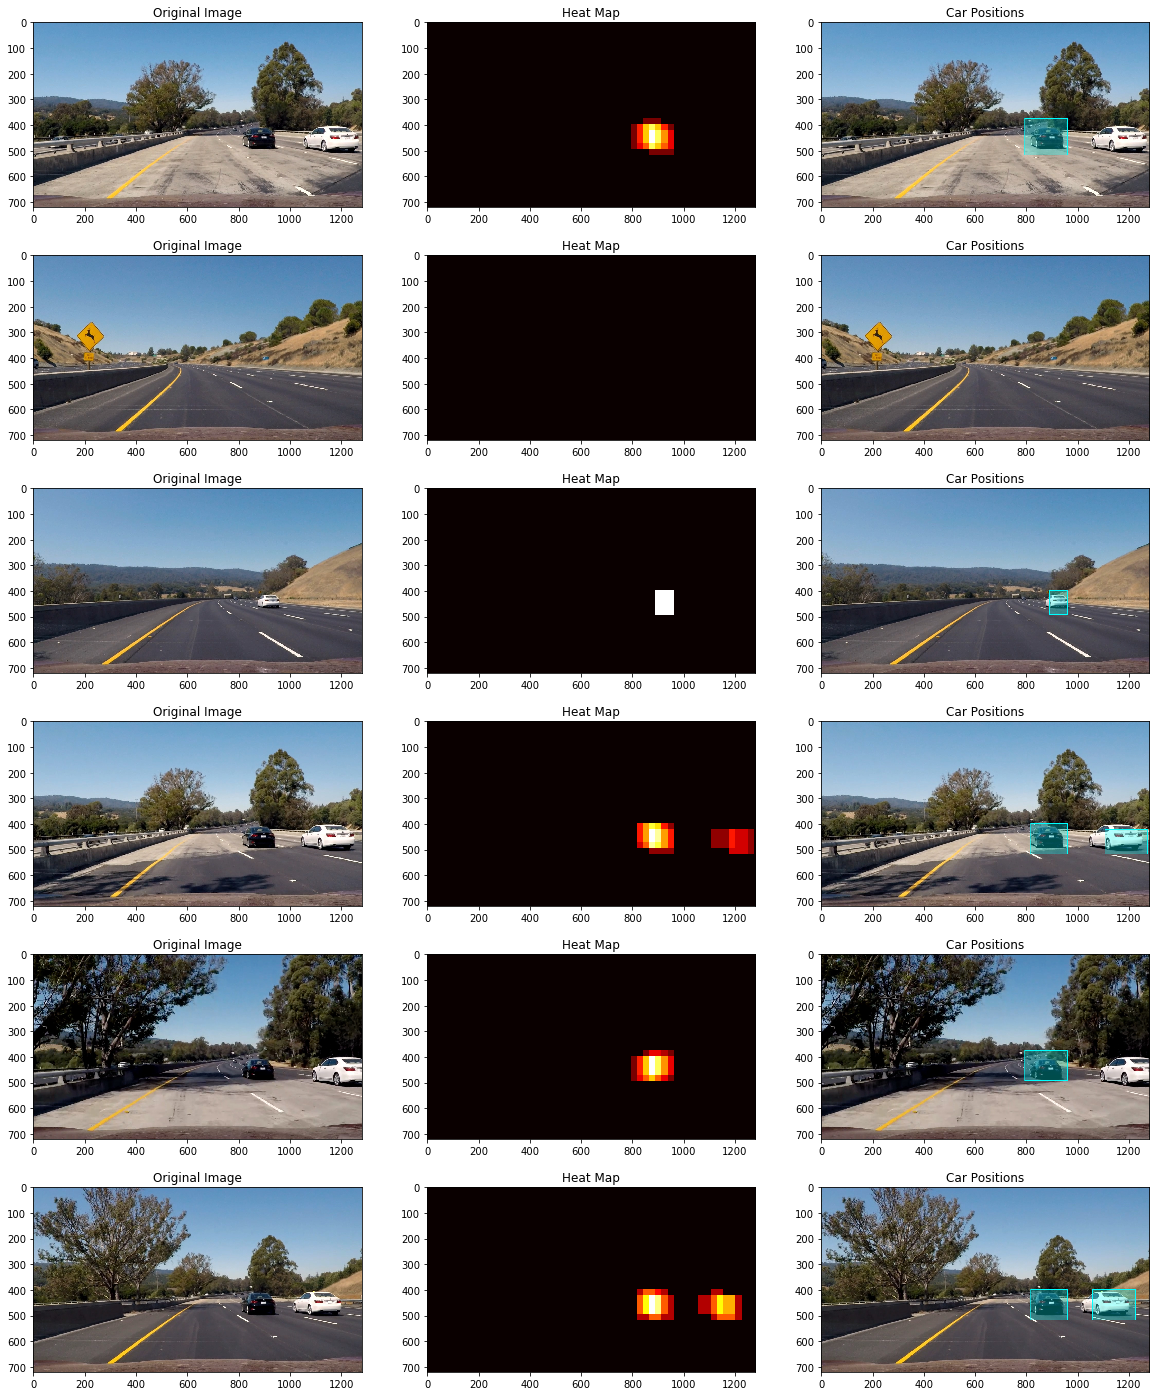

In [48]:
# Test some images
display ('test_images/test*.jpg', (20,25))

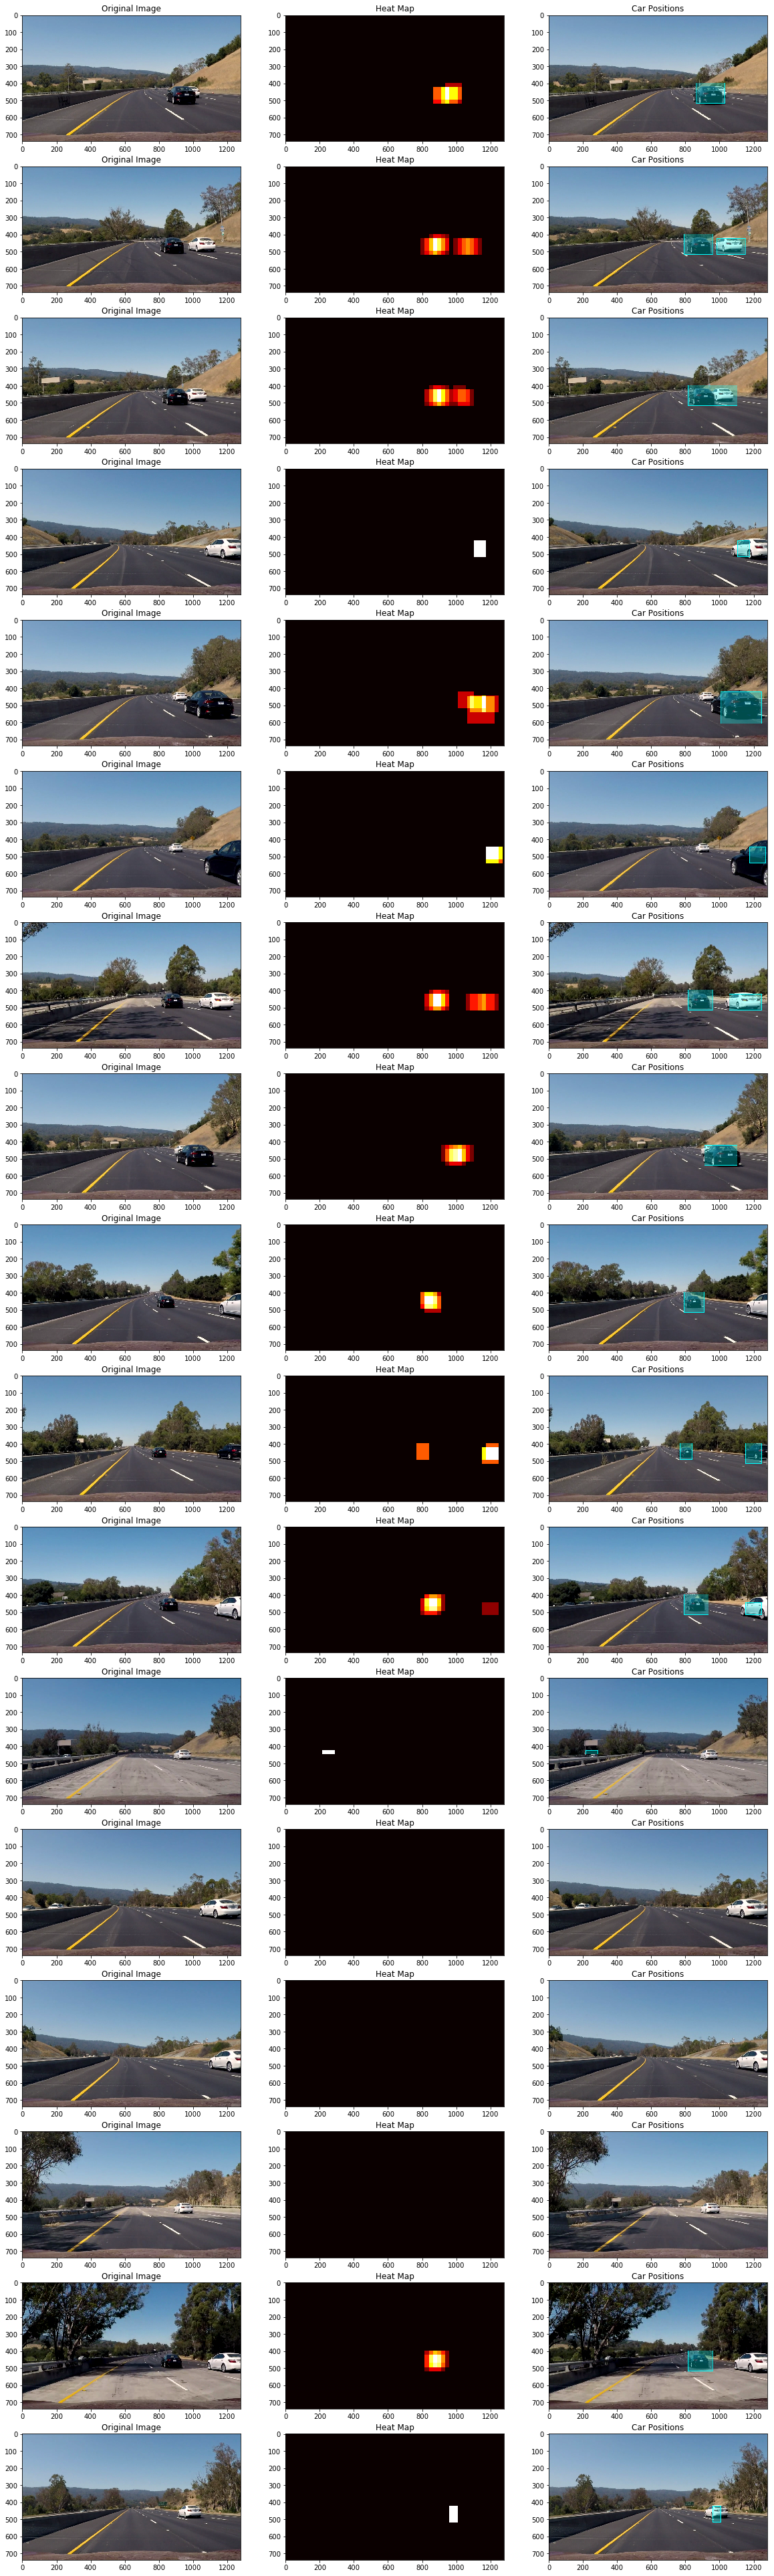

In [49]:
# Test some images
display ('more_test_images/*.jpg', (20,70))

### 7. Pipeline in VIDEO

In [67]:
class Vehicle:
    def __init__(self):
        # Hog Parameters 
        self.color_space    = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, Lab
        self.orient         = 11     # HOG orientations
        self.pix_per_cell   = 16     # HOG pixels per cell
        self.cell_per_block = 2      # HOG cells per block
        self.hog_channel    = "ALL"  # Can be 0, 1, 2, or "ALL"
        self.spatial_size   = (32,32)# Spatial binning dimensions
        self.hist_bins      = 32     # Number of histogram bins
        self.spatial_feat   = True   # Spatial features on or off
        self.hist_feat      = False  # Histogram features on or off
        self.hog_feat       = True   # HOG features on or off
        self.MLPC           = joblib.load('Dataset/MLPC_classifier.pkl')
        self.SVC            = joblib.load('Dataset/SVC_classifier.pkl')
        self.X_scaler       = joblib.load('Dataset/scaler.pkl')
        
        # Search Parameters
        self.scales         = [((96,96),[350,550],(0.75,0.75)),\
                               ((128,128),[450,700],(0.55,0.55))]
        self.windows        = []
        self.heat           = None
        self.threshold      = 6      # threshold to remove false positive
        self.lastframes     = 10     # 
        self.heat           = []
        self.heat_sum       = []
        self.blind_search   = 6      # start blind search again
        self.count          = 0
        self.last_fits      = None   # detected vehicles in last frame. 
    
    def windows_calculation(self, image):
        for window_size, y_size, overlap in self.scales:
            window = slide_window(image, x_start_stop=[None, None], y_start_stop= y_size,\
                                  xy_window= window_size, xy_overlap= overlap)
            self.windows.extend(window)
    def newwindows_calculation():
        for x in carlist:
            thiswindow = slide_window(image_test,\
                                      x_start_stop= [min(x[0][0],x[1][0]),max(x[0][0],x[1][0])],\
                                      y_start_stop= [min(x[0][1],x[1][1]),max(x[0][1],x[1][1])],\
                                      xy_window= (96,96), xy_overlap= (0.75,0.75))
            newwindows.extend(thiswindow)
    
    def heat_add(self, current_heat):
        self.heat.append(current_heat)
        self.heat = self.heat[-self.lastframes:] # get heat in last number of frames
        self.heat_sum = sum(self.heat)
        
    def expand(self, x, exp=50):
        X0 = min(x[0][0],x[1][0])-exp
        X1 = max(x[0][0],x[1][0])+exp
        Y0 = min(x[0][1],x[1][1])-exp
        Y1 = max(x[0][1],x[1][1])+exp
        return ((X0,Y0),(X1,Y1))

In [70]:
vehicle = Vehicle()
def process_video(image):
    
    '''
    1. Do blind search at default scale at each blind_search time to update known and unknown cars. 
       (Here, after 6 frames do blind search again)
    2. When we confidently know the localtion of cars in images, update new locations of known cars
    '''
    if not windows:
        vehicle.windows_calculation(image)
    
    if (vehicle.count % vehicle.blind_search) == 0:
        hot_windows = search_windows(image,vehicle.windows,vehicle.SVC,vehicle.X_scaler,\
                                     color_space=vehicle.color_space,spatial_size=vehicle.spatial_size,\
                                     hist_bins=vehicle.hist_bins,orient=vehicle.orient,\
                                     pix_per_cell=vehicle.pix_per_cell,cell_per_block=vehicle.cell_per_block,\
                                     hog_channel=vehicle.hog_channel,spatial_feat=vehicle.spatial_feat,\
                                     hist_feat=vehicle.hist_feat,hog_feat=vehicle.hog_feat,\
                                     classifier = "svc", method = "opencv")
    else:
        vehicle.carlist = [expand(x) for x in vehicle.carlist]
        newwindows = []
        for x in vehicle.carlist:
            thiswindow = slide_window(image_test,\
                                      x_start_stop= [min(x[0][0],x[1][0]),max(x[0][0],x[1][0])],\
                                      y_start_stop= [min(x[0][1],x[1][1]),max(x[0][1],x[1][1])],\
                                      xy_window= (96,96), xy_overlap= (0.7,0.7)) 
            newwindows.extend(thiswindow)
        
        hot_windows = search_windows(image,newwindows,vehicle.SVC,vehicle.X_scaler,\
                                     color_space=vehicle.color_space,spatial_size=vehicle.spatial_size,\
                                     hist_bins=vehicle.hist_bins,orient=vehicle.orient,\
                                     pix_per_cell=vehicle.pix_per_cell,cell_per_block=vehicle.cell_per_block,\
                                     hog_channel=vehicle.hog_channel,spatial_feat=vehicle.spatial_feat,\
                                     hist_feat=vehicle.hist_feat,hog_feat=vehicle.hog_feat,\
                                     classifier = "svc", method = "opencv")

        
    '''
    FALSE POSITIVE
    1. Get heat at current frame and apply threshold to remove false positives
    2. Add this heat to global heat and apply threhold again. 
    '''
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    current_heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    current_heat = apply_threshold(current_heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    carlist = draw_labeled_bboxes(np.copy(image), labels)
    
    
    # Store current heat to global heat
    vehicle.heat_add(current_heat)
    # Apply threshold to help remove false positives
    heat = apply_threshold(vehicle.heat_sum,vehicle.threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img, vehicle.carlist = draw_labeled_bboxes(np.copy(image), labels)
    
    vehicle.count += 1
    return draw_img

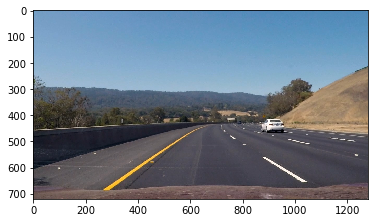

In [72]:
img = process_video (mpimg.imread('test_images/test3.jpg'))
plt.imshow(img)

In [71]:
output = 'test_video_output.mp4'
clip1 = VideoFileClip('test_video.mp4')
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:03<00:00,  9.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 5.03 s


In [ ]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)